## <center>SARIMA</center>

In [2]:
import numpy as np
import pandas as pd
from pandas import datetime
from itertools import product

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\41BC~1\AppData\Local\Temp/ipykernel_11944/3239282644.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [3]:
mcs = pd.read_csv('C:/Users/79811/anaconda3/7. monthly-champagne-sales-in-1000s (1).csv', index_col="Month", parse_dates=True)

In [4]:
pd.to_datetime(mcs.index.map(lambda x: '200'+x))

DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01', '2001-11-01', '2001-12-01',
               '2002-01-01', '2002-02-01', '2002-03-01', '2002-04-01',
               '2002-05-01', '2002-06-01', '2002-07-01', '2002-08-01',
               '2002-09-01', '2002-10-01', '2002-11-01', '2002-12-01',
               '2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01', '2003-11-01', '2003-12-01',
               '2004-01-01', '2004-02-01', '2004-03-01', '2004-04-01',
               '2004-05-01', '2004-06-01', '2004-07-01', '2004-08-01',
               '2004-09-01', '2004-10-01', '2004-11-01', '2004-12-01',
               '2005-01-01', '2005-02-01', '2005-03-01', '2005-04-01',
               '2005-05-01', '2005-06-01', '2005-07-01', '2005-08-01',
      

In [5]:
mcs.index = pd.to_datetime(mcs.index.map(lambda x: '200'+x))

In [6]:
mcs.head()

,Monthly champagne sales (in 1000's) (p.273: Montgomery: Fore. & T.S.)
Month,
2001-01-01,2851
2001-02-01,2672
2001-03-01,2755
2001-04-01,2721
2001-05-01,2946


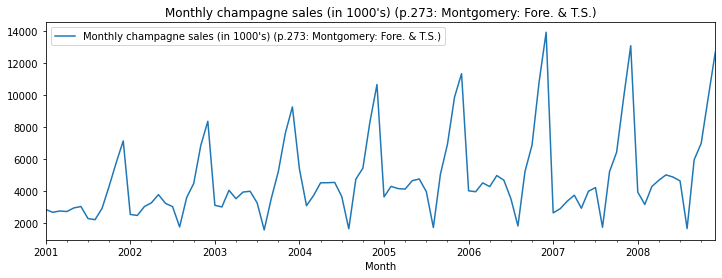

In [7]:
mcs.plot(figsize=(12,4))
plt.title("Monthly champagne sales (in 1000's) (p.273: Montgomery: Fore. & T.S.)")
plt.show()

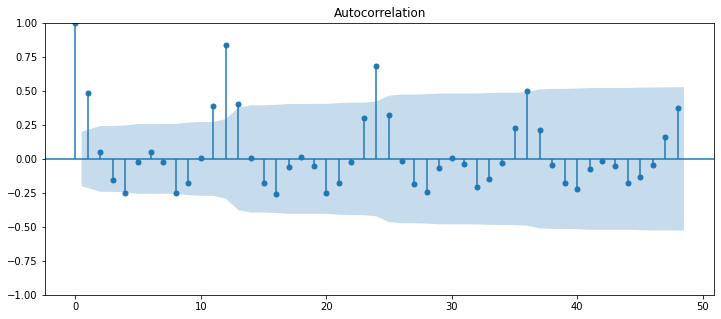

In [11]:
plt.rcParams["figure.figsize"] = (12,5)
plot_acf(mcs.dropna(), lags=48)
plt.show()

# <center>Определение порядка авторегрессии</center>

## 1. Автокорреляция и частичная автокорреляция

In [7]:
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

In [8]:
mcs_transformed, lmbda = boxcox(mcs["Monthly champagne sales (in 1000's) (p.273: Montgomery: Fore. & T.S.)"])
y_transformation = pd.DataFrame(mcs["Monthly champagne sales (in 1000's) (p.273: Montgomery: Fore. & T.S.)"].values, columns=['initial'])
y_transformation['transformed'] = mcs_transformed
y_transformation['seasonal_diff'] = y_transformation['transformed'].diff(12)
y_transformation['lag1_diff'] = y_transformation['seasonal_diff'].diff(1)

In [9]:
print("Критерий Дики-Фуллера для исходного ряда: p=%f" % adfuller(y_transformation['initial'])[1])
print("После преобразования Бокса-Кокса: p=%f" % adfuller(y_transformation['transformed'])[1])
print("После сезонного дифференцирования: p=%f" % adfuller(y_transformation['seasonal_diff'].dropna())[1])
print("После дополнительного дифференцирования: p=%f" % adfuller(y_transformation['lag1_diff'].dropna())[1])

Критерий Дики-Фуллера для исходного ряда: p=0.462683
После преобразования Бокса-Кокса: p=0.321278
После сезонного дифференцирования: p=0.008983
После дополнительного дифференцирования: p=0.000000


Рассмотрим коррелограмму полученного ряда.

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

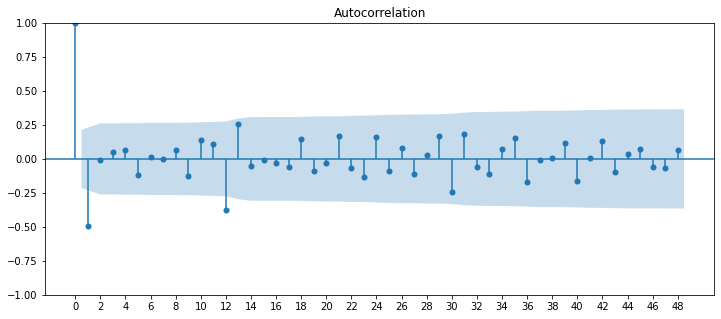

In [11]:
plt.rcParams['figure.figsize'] = (12,5)
plot_acf(y_transformation['lag1_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

Для выбора оптимальных значений гиперпараметров  𝑝 ,  𝑞 ,  𝑃  и  𝑄  необходимо построить соответствующие модели авторегрессии и оценить их качество.

In [12]:
p = range(0, 3)
q = range(0, 3)
P = range(0, 2)
Q = range(0, 2)
d = 1

In [13]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

36

Получили 36 возможных наборов гиперпараметров.

## 2. Построение модели SARIMA

Обучим модель SARIMA(1,1,0),(1,1,1).

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [15]:
model = SARIMAX(y_transformation['initial'], 
                order=(1, 1, 0), 
                seasonal_order=(1, 1, 1, 12)).fit()

Значение критерия Акаике:

In [16]:
model.aic

1367.283704653661

Прогноз модели получим с помощью функций forecast и predict.

In [17]:
model.params

ar.L1           -0.307353
ar.S.L12        -0.568339
ma.S.L12         0.325315
sigma2      715039.299060
dtype: float64

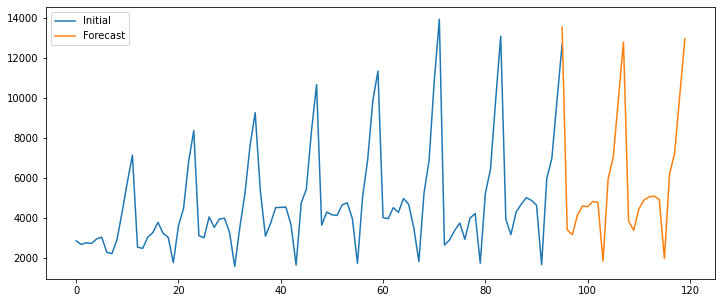

In [22]:
y_transformation['initial'].plot(figsize=(12,5))
model.predict(start = y_transformation['initial'].index[-1], end = y_transformation['initial'].index[-1] + 24).plot()
plt.legend(['Initial', 'Forecast'])
plt.show()

In [20]:
minn = 10000;

for i in parameters_list:
    model = SARIMAX(y_transformation['initial'], 
    order = (i[0], 1, i[1]), seasonal_order=(i[2], 1, i[3], 12)).fit()
    if model.aic < minn:
        minn = model.aic;
        minn1 = i;
print (minn, minn1)

C:\Users\79811\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\79811\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\79811\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\79811\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\79811\anaconda3\lib\s

1347.8721988042362 (1, 1, 1, 0)


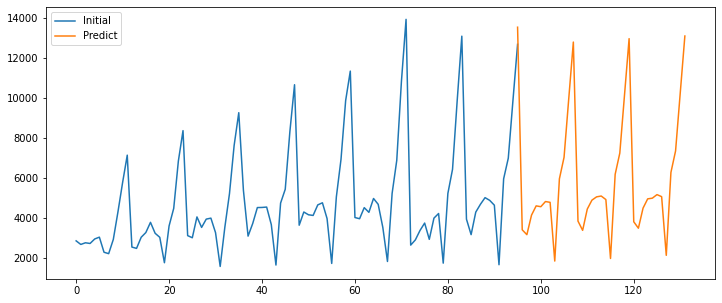

In [21]:
y_transformation['initial'].plot(figsize=(12,5))
model.predict(start = y_transformation['initial'].index[-1], end = y_transformation['initial'].index[-1] + 36).plot()
plt.legend(['Initial', 'Predict'])
plt.show()